# Housing Prices

The main goal of this project is to predict the sales price of each house in the dataset.

# 0. Libreries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# 1. Data

In [46]:
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')

print("Train shape: ", train_raw.shape)
print("Test shape: ", test_raw.shape)

train_raw.head()

Train shape:  (1460, 81)
Test shape:  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


A preliminar analysis of the data reveals the pressence of null values and categorical featurexs, which will be processed in the following sections.

## 1.1. Exploration and Profiling

This section analyzes the dataset to identify null values, duplicates, and outliers, as well as its overall distribution and statistical properties. This evaluation ensures data quality and supports the proper functioning of the model.

This processs of dropping columns alters the dimensionality of the dataset. Therefore, the same changes must be applied to the test set to mantain the consistency and ensure proper model performance.


In [47]:
data_train = train_raw.copy()
data_test = test_raw.copy()

data_train.drop(columns=['Id'], inplace=True)
data_test.drop(columns=['Id'], inplace=True)

### 1.1.1. Duplicate entries and missing values

In [48]:
data_train.duplicated().sum()

0

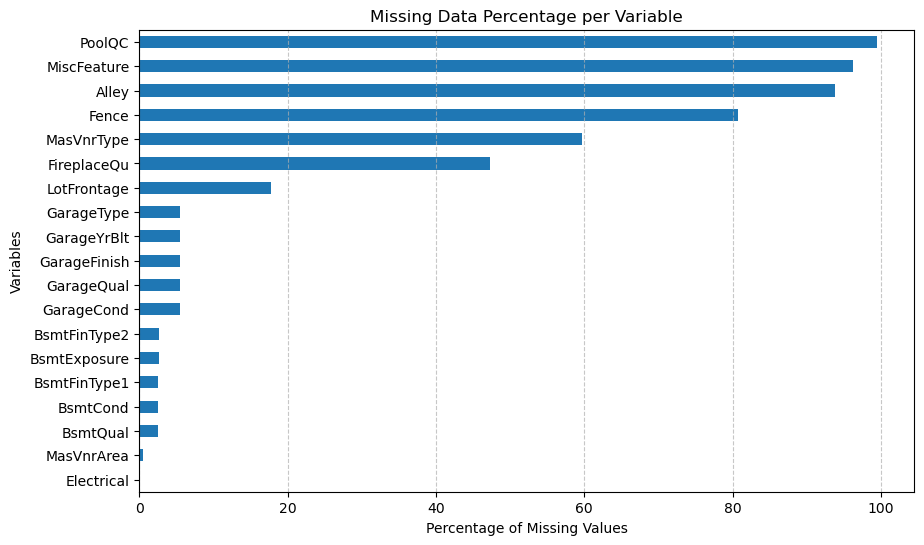

In [49]:
# Extracting the percentage of missing values per column
missing = data_train.isna().mean() * 100
missing = missing[missing > 0]
missing.sort_values(inplace=True)

# Plotting the missing values
plt.figure(figsize=(10, 6))
missing.plot(kind='barh')
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Variables")
plt.title("Missing Data Percentage per Variable")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


The dataset does not contain duplicate values. However, as previusly mentioned, some variables have missing values. In such cases,  imputation techniques or data removal can be applied.

For variables with a high percentage of missing values, such as FireplaceQu, MasVnrType, Fence, Alley, MiscFeature, and PoolQC (all exceeding 40% missing data), imputation is not justified. Therefore, these variables were removed. For the remaining variables, imputation techniques such as mean, median, or most frequent value were applied."

In [50]:
data_train.drop(columns=missing[missing > 40].index, inplace=True)
data_test.drop(columns=missing[missing > 40].index, inplace=True)
print('total columns:', data_train.shape[1])

total columns: 74


### 1.1.2. Zeros

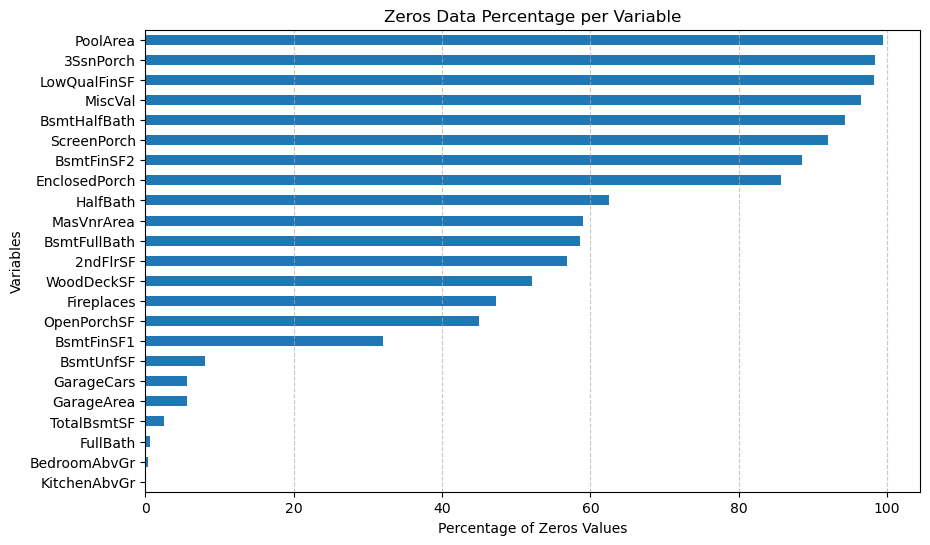

In [51]:
# Percentage of zeros values per column
zeros = (data_train == 0).mean() * 100
zeros = zeros[zeros > 0]
zeros.sort_values(inplace=True)

# Plotting the missing values
plt.figure(figsize=(10, 6))
zeros.plot(kind='barh')
plt.xlabel("Percentage of Zeros Values")
plt.ylabel("Variables")
plt.title("Zeros Data Percentage per Variable")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [52]:
data_train.drop(columns=zeros[zeros > 40].index, inplace=True)
data_test.drop(columns=zeros[zeros > 40].index, inplace=True)
print('total columns:', data_train.shape[1])

total columns: 59


### 1.1.3. Correlation

In [53]:
# Extract de numerical columns
numerical_cols = data_train.select_dtypes(include=np.number).columns.tolist()
print('Numerical columns:', len(numerical_cols))

Numerical columns: 22


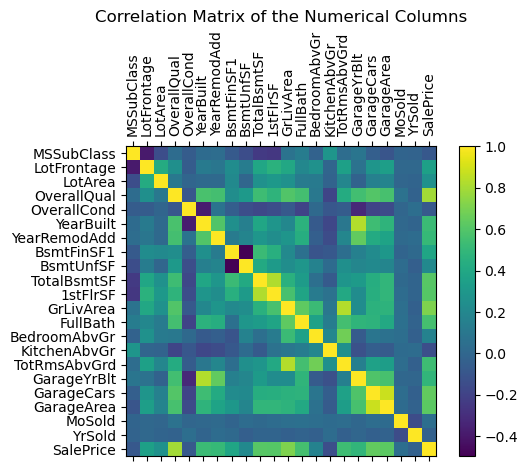

In [54]:
# Correlation matrix of the numerical columns
corr_matrix = data_train[numerical_cols].corr()

# Plotting the correlation matrix
plt.figure(figsize=(6, 4))
plt.matshow(corr_matrix, fignum=1)
plt.colorbar()
plt.title("Correlation Matrix of the Numerical Columns")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()


In [55]:
# Extracting the highly correlated pairs
high_corr = corr_matrix.abs().unstack()
high_corr = high_corr[high_corr > 0.8]
high_corr = high_corr[high_corr < 1]
high_corr = high_corr.reset_index()
high_corr.columns = ['feature1', 'feature2', 'corr']
high_corr = high_corr[high_corr['corr'] > 0.8]
high_corr

,feature1,feature2,corr
0,YearBuilt,GarageYrBlt,0.825667
1,TotalBsmtSF,1stFlrSF,0.819530
2,1stFlrSF,TotalBsmtSF,0.819530
3,GrLivArea,TotRmsAbvGrd,0.825489
4,TotRmsAbvGrd,GrLivArea,0.825489
5,GarageYrBlt,YearBuilt,0.825667
6,GarageCars,GarageArea,0.882475
7,GarageArea,GarageCars,0.882475


In [56]:
# Drop the highly correlated columns
data_train.drop(columns=high_corr['feature1'].unique(), inplace=True)
data_test.drop(columns=high_corr['feature1'].unique(), inplace=True)

print('total columns:', data_train.shape[1])

total columns: 51


## 1.2. Preprocessing

This section prepares the training set to ensure the algorithm's proper performace.

To achive this, a pipeline will be used to process the data efficiently. The steps include imputing missing values (mean or median for numerical values and most frequent for categorical values), scaling numerical features (RobustScaler, StandardScaler, MinMaxScaler) and applaying One-Hot Encoding to categorical columns.

In [57]:
x_train = data_train.drop(columns=['SalePrice'])
y_train = data_train['SalePrice']

In [58]:
# Extract the numerical columns
numerical_cols = x_train.select_dtypes(include=np.number).columns.tolist()
print('Numerical columns:', len(numerical_cols))
print(numerical_cols)

Numerical columns: 13
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'MoSold', 'YrSold']


In [59]:
x_train = pd.get_dummies(
    x_train,
    columns = x_train.select_dtypes(include='object').columns,
    dtype = int
)

x_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,FullBath,BedroomAbvGr,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,706,150,2,3,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,978,284,2,3,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2002,486,434,2,3,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1970,216,540,1,3,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,655,490,2,4,...,0,0,0,1,0,0,0,0,1,0


In [60]:
num_transformer = Pipeline([
    ('imputer', SimpleImputer()),
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols)
    ]
)

# 2. Model

## 2.1. KFold

KFolds  cross-validation is used to evaluate  different training-validation splits within the training set. This approach helps improve the model's  convergence by providing a more reliable estimation through multiple training and validation combinations.

In [61]:
kfold =  KFold(n_splits = 5 , shuffle = True , random_state = 26)

## 2.2. GridSearchCV

GridSearchCV is used to evaluate different hyperparameter configurations. In this case, it tests various imputers, polynomial features transformations and scalers for numerical features, as well as regularization and other hyperparameters of the Regression Model.

### 2.2.1. Linear Regresion

In [62]:
pipeline_linear = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

param_grid_linear  = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__num__poly__degree': [1, 2, 3],
    'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()]
}

## 2.3. Train

### 2.3.1. Linear Regresion

In [63]:
models_linear = GridSearchCV(pipeline_linear, param_grid_linear, cv=kfold)

In [64]:
models_linear.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=26, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearRemodAdd',
                                                                          'BsmtFinSF1',
                                                                          'BsmtUnfSF',
                                                                          'FullBath',
                                                                          'BedroomAbvGr',
                                                                          'KitchenAbvGr',
                                                                          'MoSold',
                                                                          'YrSold'])])),
                                       ('model', LinearRegression())]),
             param_grid={'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median'],
                         'preprocessor__num__poly__degree': [1, 2, 3],
                         'preprocessor__num__scaler': [StandardScaler(),
                                                       RobustScaler(),
                                                       MinMaxScaler()]})

In [65]:
print("Best parameters: ", models_linear.best_params_)

Best parameters:  {'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__poly__degree': 2, 'preprocessor__num__scaler': RobustScaler()}


In [66]:
best_model_linear = models_linear.best_estimator_

## Evaluation

In [67]:
y_pred = best_model_linear.predict(data_test)


y_test = pd.read_csv('data/sample_submission.csv')
y_test = y_test['SalePrice']

rmse = root_mean_squared_error(y_test, y_pred)
print("RMSE: ", rmse)

RMSE:  71471.28590293835
